<a href="https://colab.research.google.com/github/yajima-yasutoshi/Model/blob/main/20250625/%E8%BC%B8%E9%80%81%E5%95%8F%E9%A1%8C%E8%A7%A3%E8%AA%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 環境の準備

In [ ]:
#表示を抑制する
%%capture

# python-mip ライブラリをインストールする
!pip install mip

# Matplotlibで日本語を表示するためのライブラリをインストール
!pip install japanize-matplotlib

# 輸送問題

## 輸送問題の概要

輸送問題（Transportation Problem）は、
複数の供給地（例: 工場）から複数の需要地（例: 倉庫、店舗）へ物資を輸送する際に、総輸送コストを最小化するような輸送計画を決定する問題である。各供給地には供給可能な量の上限があり、各需要地には満たすべき需要量がある。また、各供給地と需要地の間の輸送には単位あたりのコストが定められている。

この問題は、物流ネットワークにおける効率的な資源配分を決定するための基本的なモデルとして広く利用されている。


##例題

ある企業が2つの工場（供給地 $F_1, F_2$）と3つの倉庫（需要地 $W_1, W_2, W_3$）を持っているとする。各工場からの製品供給可能量、各倉庫での製品需要量、および各工場から各倉庫への製品1単位あたりの輸送コストが以下の表で与えられている。

|             | 倉庫 $W_1$ | 倉庫 $W_2$ | 倉庫 $W_3$ | 供給量 |
| :---------- | :--------: | :--------: | :--------: | :----: |
| 工場 $F_1$ |     4      |     6      |     5      |  100   |
| 工場 $F_2$ |     7      |     5      |     8      |  180   |
| **需要量** |     80     |     90     |    110     |        |

目標は、総輸送コストを最小にするように、どの工場からどの倉庫へどれだけの量の製品を輸送するかを決定することである。


###輸送問題の図示

輸送問題は、供給地と需要地をノード、輸送路を枝とした以下のようなグラフとして図示される。このようなグラフは**二部グラフ**と呼ばれる。


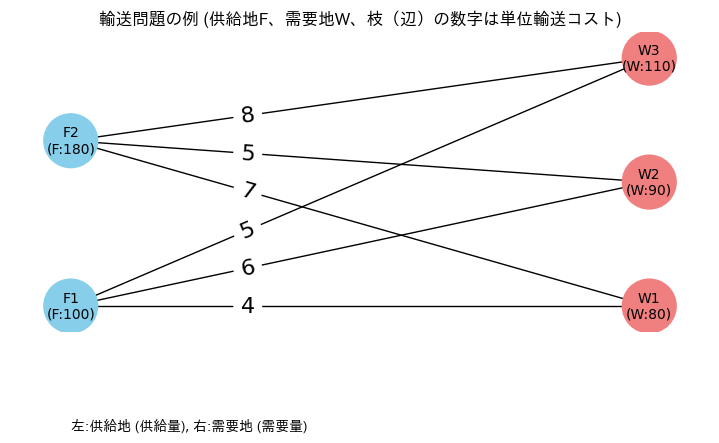

In [ ]:
#@title 二部グラフ
# 必要なライブラリをインポートする
import matplotlib.pyplot as plt
import networkx as nx
import japanize_matplotlib # ← 日本語表示のためにインポート
import random

# 例題データ
supply_nodes = ['F1', 'F2']
demand_nodes = ['W1', 'W2', 'W3']
supplies = {'F1': 100, 'F2': 180}
demands = {'W1': 80, 'W2': 90, 'W3': 110}
costs = {
    ('F1', 'W1'): 4, ('F1', 'W2'): 6, ('F1', 'W3'): 5,
    ('F2', 'W1'): 7, ('F2', 'W2'): 5, ('F2', 'W3'): 8
}

# グラフの作成 (二部グラフ)
B = nx.Graph()
# ノードを追加 (供給側と需要側で属性を設定)
for i, s_node in enumerate(supply_nodes):
    B.add_node(s_node, demand=0, supply=supplies[s_node], type='supply', pos=(0, i*2))
for i, d_node in enumerate(demand_nodes):
    B.add_node(d_node, demand=demands[d_node], supply=0, type='demand', pos=(3, i*1.5))

# 辺 (輸送経路) を追加 (コストを属性として)
for (s_node, d_node), cost_val in costs.items():
    B.add_edge(s_node, d_node, weight=cost_val, capacity=float('inf')) # capacityはここでは使わない

pos_tp = nx.get_node_attributes(B, 'pos')
node_labels_tp = {node: f"{node}\n(F:{data['supply']})" if data['type']=='supply' else f"{node}\n(W:{data['demand']})"
                  for node, data in B.nodes(data=True)}
edge_labels_tp = nx.get_edge_attributes(B, 'weight')


# 図示
plt.figure(figsize=(7, 3))
nx.draw(B, pos_tp, with_labels=False, node_size=1500, node_color=['skyblue' if B.nodes[node]['type']=='supply' else 'lightcoral' for node in B.nodes()])
nx.draw_networkx_labels(B, pos_tp, labels=node_labels_tp, font_size=10)
nx.draw_networkx_edge_labels(B, pos_tp, edge_labels=edge_labels_tp, font_size=16, label_pos=0.3) # コスト表示

plt.title("輸送問題の例 (供給地F、需要地W、枝（辺）の数字は単位輸送コスト)")
plt.text(0, -1.5, "左:供給地 (供給量), 右:需要地 (需要量)", ha='left')
plt.axis('off') # 軸を非表示
plt.show()

### 実社会での応用例

輸送問題のモデルは、その単純さにもかかわらず、多くの実用的な場面で応用されている。

* **物流・サプライチェーン**: 製品を工場から倉庫へ、倉庫から小売店へ、あるいは直接顧客へ配送する際の最小コスト計画。
* **資源配分**: 電力や水道などの公益事業において、複数の発電所や浄水場から各地域への効率的な資源配分計画。
* **生産計画**: 複数の工場で生産された製品を、複数の市場や倉庫に割り当てる際のコスト最小化（生産コストも考慮に入れると生産輸送問題となる）。
* **人員配置**: 複数の拠点にいる作業員を、複数の作業現場に割り当てる際の移動コストや人件費の最小化（割り当て問題との関連）。
* **災害時の物資輸送**: 救援物資を備蓄拠点から被災地の避難所へ効率的に輸送する計画。

これらの応用では、輸送コストだけでなく、時間、距離、容量なども考慮に入れたより複雑なモデルへと発展することが多い。

## 定式化

輸送問題を数理モデルとして定式化する。

### 1. 変数の定義

決定すべきは、各工場から各倉庫への輸送量である。これを変数として定義する。

* $x_{ij}$: 工場 $i$ から倉庫 $j$ への輸送量 ($i \in \{F_1, F_2\}$, $j \in \{W_1, W_2, W_3\}$)

上のように定義すると、例えば変数
$$x_{F1, W1}$$
は工場 $F_1$ から倉庫 $W_1$ への輸送量を表す。

###制約条件

輸送計画が満たすべき条件を記述する。

* **供給制約:** 各工場からの輸送量の合計は、その工場の供給量を超えてはならない。
    * 工場 $F_1$: $x_{F1, W1} + x_{F1, W2} + x_{F1, W3} \leq 100$
    * 工場 $F_2$: $x_{F2, W1} + x_{F2, W2} + x_{F2, W3} \leq 180$
* **需要制約:** 各倉庫への輸送量の合計は、その倉庫の需要量を満たさなければならない。
    * 倉庫 $W_1$: $x_{F1, W1} + x_{F2, W1} \geq 80$
    * 倉庫 $W_2$: $x_{F1, W2} + x_{F2, W2} \geq 90$
    * 倉庫 $W_3$: $x_{F1, W3} + x_{F2, W3} \geq 110$
* **非負制約:** 輸送量は負の値を取ることはできない。
    * $x_{ij} \geq 0$  for all $i, j$

**注意:**
この例題では、総供給量
$$100 + 180 = 280$$
と総需要量

$$80 + 90 + 100 = 280$$

が一致しており、
かつ、
どの工場からどの倉庫にへも輸送できることから、
供給制約と需要制約は等号（=）で結ぶことができる。

特にこのような場合を、
**バランス型の輸送問題**と呼ぶ。

* **供給制約:**
    * 工場 $F_1$: $x_{F1, W1} + x_{F1, W2} + x_{F1, W3} = 100$
    * 工場 $F_2$: $x_{F2, W1} + x_{F2, W2} + x_{F2, W3} = 180$
* **需要制約:**
    * 倉庫 $W_1$: $x_{F1, W1} + x_{F2, W1} = 80$
    * 倉庫 $W_2$: $x_{F1, W2} + x_{F2, W2} = 90$
    * 倉庫 $W_3$: $x_{F1, W3} + x_{F2, W3} = 110$

一般的には、総供給量の方が総需要量を超えるように設定される
（このような場合を**アンバンス型**と呼ぶ場合もある）
ことが多く、制約条件も不等号で設定されるが、
ダミーの需要ノードを加え、
全ての共有ノードからコスト0で輸送できる枝を
追加することで、等式のモデル化が可能である。

###目的関数

最小化したい総輸送コストを記述する。これは、各経路の輸送量とその経路の単位輸送コストの積を、全ての経路について合計したものである。

* **最小化:** $Z = 4x_{F1, W1} + 6x_{F1, W2} + 5x_{F1, W3} + 7x_{F2, W1} + 5x_{F2, W2} + 8x_{F2, W3}$

## 数理モデル

上記を一般的な数式で表現する。

**インデックス:**
* $i$: 供給地（工場）のインデックス ($i = 1, ..., m$)
* $j$: 需要地（倉庫）のインデックス ($j = 1, ..., n$)

**パラメータ(定数):**
* $s_i$: 供給地 $i$ の供給量
* $d_j$: 需要地 $j$ の需要量
* $c_{ij}$: 供給地 $i$ から需要地 $j$ への単位輸送コスト

**変数:**
* $x_{ij}$: 供給地 $i$ から需要地 $j$ への輸送量

**定式化:**

* **目的関数 (最小化):**
    $$\min Z = \sum_{i=1}^{m} \sum_{j=1}^{n} c_{ij} x_{ij}$$
* **制約条件:**
    * 供給制約:
        $$\sum_{j=1}^{n} x_{ij} \le s_i \quad (\forall i = 1, ..., m)$$
    * 需要制約:
        $$\sum_{i=1}^{m} x_{ij} \ge d_j \quad (\forall j = 1, ..., n)$$
    * 非負制約:
        $$x_{ij} \geq 0 \quad (\forall i = 1, ..., m, \forall j = 1, ..., n)$$

なお、変数が連続値であり、目的関数と制約条件がすべて線形であるため、
これは**線形計画問題（Linear Programming, LP）**である。


## `python-mip` による実装

Pythonの `mip` パッケージを用いて、上記の例題を解く。

In [ ]:
#パッケージのインポート
import numpy as np
import pandas as pd

# --- データ定義 ---
# 供給地 (Factories) と 需要地 (Warehouses)
factories = ['F1', 'F2']
warehouses = ['W1', 'W2', 'W3']

# 供給量 (Supply)
supply = {'F1': 100, 'F2': 180}

# 需要量 (Demand)
demand = {'W1': 80, 'W2': 90, 'W3': 110}

# 輸送コスト (Cost)
# DataFrame形式で定義すると見やすい
cost_data = [[4, 6, 5],
             [7, 5, 8]]
costs = pd.DataFrame(cost_data, index=factories, columns=warehouses)
print("--- 輸送コスト ---")
print(costs)
print("\n--- 供給量 ---")
print(pd.Series(supply))
print("\n--- 需要量 ---")
print(pd.Series(demand))

# 総供給量と総需要量の確認 (バランス型か)
total_supply = sum(supply.values())
total_demand = sum(demand.values())
print(f"\n総供給量: {total_supply}")
print(f"総需要量: {total_demand}")
if total_supply != total_demand:
    print("警告: 総供給量と総需要量が一致しません。アンバランス型問題です。")
    # ここではバランス型を仮定して進める


--- 輸送コスト ---
    W1  W2  W3
F1   4   6   5
F2   7   5   8

--- 供給量 ---
F1    100
F2    180
dtype: int64

--- 需要量 ---
W1     80
W2     90
W3    110
dtype: int64

総供給量: 280
総需要量: 280


In [ ]:
import mip
# --- モデル構築 ---
# モデルの作成
model = mip.Model(name="TransportationProblem", sense=mip.MINIMIZE)

# 変数の定義
# x[i, j] は工場 i から倉庫 j への輸送量を表す
x = {}
for i in factories:
    for j in warehouses:
        # 変数名は f"x({i},{j})" のように設定
        # 非負の連続変数 (var_type=mip.CONTINUOUS, lb=0)
        x[i, j] = model.add_var(name=f"x({i},{j})", var_type=mip.CONTINUOUS, lb=0)

print(f"\n作成された変数の数: {len(x)}")


作成された変数の数: 6


###制約条件の追加

追加する制約条件は以下の通りであった。

* 供給制約:
$$
\sum_{j=1}^{n} x_{ij} \le s_i \quad (\forall i = 1, ..., m)
$$
* 需要制約:
$$
\sum_{i=1}^{m} x_{ij} \ge d_j \quad (\forall j = 1, ..., n)
$$


In [ ]:
# --- 制約条件の追加 ---
# 1. 供給制約: 各工場からの輸送量は供給量に等しい
for i in factories:
    model.add_constr(mip.xsum(x[i, j] for j in warehouses) <= supply[i], name=f"supply_{i}")
    # print(f"供給制約 ({i}) 追加: sum(x[{i},j] for j in W) <= {supply[i]}")

# 2. 需要制約: 各倉庫への輸送量は需要量に等しい
for j in warehouses:
    model.add_constr(mip.xsum(x[i, j] for i in factories) >= demand[j], name=f"demand_{j}")
    # print(f"需要制約 ({j}) 追加: sum(x[i,{j}] for i in F) >= {demand[j]}")

### 目的関数の設定

目的関数は、以下の通りであった。
$$
\min Z = \sum_{i=1}^{m} \sum_{j=1}^{n} c_{ij} x_{ij}
$$

In [ ]:
# --- 目的関数の設定 ---
# 総輸送コストを最小化する
model.objective = mip.xsum(costs.loc[i, j] * x[i, j] for i in factories for j in warehouses)
# print("\n目的関数設定: Minimize sum(cost[i,j] * x[i,j])")

###最適化の実行と結果の表示

In [ ]:
# --- モデルの求解 ---
print("\n--- 求解開始 ---")
status = model.optimize()
print(f"求解ステータス: {status}")

# --- 結果の表示と解釈 ---
if status == mip.OptimizationStatus.OPTIMAL or status == mip.OptimizationStatus.FEASIBLE:
    print(f"\n最適解発見 (または実行可能解発見)")
    print(f"最小総輸送コスト (最適値): {model.objective_value:.2f}")

    # 最適な輸送計画を表示
    print("\n--- 最適輸送計画 ---")
    transport_plan = pd.DataFrame(index=factories, columns=warehouses)
    for i in factories:
        for j in warehouses:
            # 輸送量が非常に小さい値は0とみなす（数値誤差対策）
            transport_plan.loc[i, j] = x[i, j].x if x[i, j].x > 1e-6 else 0
    print(transport_plan)
elif status == mip.OptimizationStatus.INFEASIBLE:
    print("\n実行不可能: 制約を満たす解が存在しません。")
elif status == mip.OptimizationStatus.UNBOUNDED:
    print("\n非有界: 目的関数を無限に小さく（または大きく）できます。")
else:
    print(f"\n求解失敗 (ステータス: {status})")


--- 求解開始 ---
求解ステータス: OptimizationStatus.OPTIMAL

最適解発見 (または実行可能解発見)
最小総輸送コスト (最適値): 1590.00

--- 最適輸送計画 ---
      W1    W2     W3
F1     0     0  100.0
F2  80.0  90.0   10.0


## 輸送問題の解法と性質

* **線形計画問題 (Linear Programming Problem)**:
    輸送問題は、目的関数と全ての制約条件が線形であるため、線形計画問題 (LP) に分類される。LPは効率的な解法（シンプレックス（単体）法や内点法など）が存在し、MIPソルバーはこれらを利用して大規模な問題でも比較的短時間で最適解を求めることができる。

* **整数性 (Integrality Property)**:
もし全ての供給量 $a_i$ と需要量 $b_j$ が整数である場合、輸送問題のLPとしての最適解において、全ての輸送量 $x_{ij}$ も整数値を取るという重要な性質がある（基底解が整数となる）。これは、特殊なネットワーク構造を持つLPの一般的な特性である。したがって、$x_{ij}$ を明示的に整数変数として定義しなくても、結果として整数解が得られる。

* **専用アルゴリズム (古典的解法)**:
    MIPソルバーが普及する以前は、輸送問題の特殊な構造を利用した専用の解法アルゴリズムが開発され、用いられていた。
    * **初期実行可能解の発見**:
        * **北西隅法 (Northwest Corner Rule)**: 表の左上（北西隅）から順に、供給または需要が尽きるまで割り当てる単純な方法。
        * **最小コスト法 (Least Cost Method / Matrix Minimum Method)**: コストが最も小さいセルから順に可能な限り割り当てる方法。
        * **フォーゲルの近似法 (Vogel's Approximation Method, VAM)**: 各行・各列で最小コストと次に小さいコストの差（ペナルティ）を計算し、ペナルティが最大の行または列で最小コストのセルに割り当てる方法。通常、上記2つより良い初期解を与える。
    * **最適解への改善**:
        * **ステッピングストーン法 (Stepping Stone Method)**: 空きセル（輸送量0の経路）に少量輸送した場合のコスト変化を評価し、コストが改善するならループ上の輸送量を調整して解を改善する反復法。
        * **MODI法 (Modified Distribution Method / Multiplier Method)**: 双対変数（ポテンシャル）を用いて各空きセルの評価を効率的に行い、解を改善する。ステッピングストーン法より計算効率が良い。
    これらの古典的アルゴリズムは、LPのシンプレックス法の特殊化と見なすことができる。現代では、汎用MIPソルバーがこれらの問題を効率的に解くため、手計算でこれらのアルゴリズムを適用する機会は減っているが、問題の構造理解には役立つ。

* **双対問題 (Dual Problem)**:
    全てのLPには対応する双対問題が存在する。輸送問題の双対問題は、各供給地にポテンシャル（潜在価格）$u_i$、各需要地にポテンシャル $v_j$ を割り当て、$u_i + v_j \le c_{ij}$ (輸送が行われる経路では等号) を満たしつつ、$\sum a_i u_i + \sum b_j v_j$ を最大化する問題となる。これらの双対変数は、資源の限界価格や機会費用といった経済的な解釈を与えることがある。

---
#小テスト

各質問に対して、正しい選択肢を全て選べ。

###**問1:** 輸送問題の主な目的として正しいものを全て選べ。

(a) 各供給地から各需要地への輸送量を最大化する。

(b) 総輸送コストを最小化する。

(c) 最適解では必ず全ての供給地の供給量を完全に使い切る。

(d) 最適解では必ず全ての需要地の需要量を満たす。

(e) 輸送経路の数を最小化する。


###**問2:** 「バランス型輸送問題」とはどのような状態を指すか。正しいものを全て選べ。


(a) 全ての供給地から全ての需要地への輸送コストが等しい。

(b) 各供給地の供給量が全て等しく、かつ各需要地の需要量も全て等しい。

(c) 総供給量が総需要量と等しい。

(d) 最適な輸送計画において、全ての輸送経路が同じ量の物品を輸送する。

(e) 全ての供給地が全ての需要地に物品を輸送する。

###**問3:** 講義で説明した輸送問題の数理モデルにおける決定変数 $x_{ij}$ は何を表すか。
正しいものを全て選べ。

(a) 供給地 $i$ から需要地 $j$ へ単位量輸送するためのコスト。

(b) 供給地 $i$ の総供給量。

(c) 需要地 $j$ の総需要量。

(d) 供給地 $i$ から需要地 $j$ への輸送量。

(e) 供給地 $i$ から需要地 $j$ へ輸送経路が存在するかどうかを示すバイナリ変数。

###**問4:** 輸送問題の基本的な制約条件として正しいものを全て選べ。

(a) 各供給地からの総輸送量は、その供給地の供給能力以下でなければならない（または等しい）。

(b) 各需要地への総輸送量は、その需要地の需要量以上でなければならない（または等しい）。

(c) 全ての輸送量は0または1の整数でなければならない。

(d) 総輸送コストは、あらかじめ定められた予算以内でなければならない。

(e) 各供給地は、少なくとも一つの需要地に輸送しなければならない。


###**問5:** 輸送問題の性質や解法について正しい記述を全て選べ。

(a) 輸送問題はNP困難な問題であり、大規模な問題の最適解を得るのは非常に難しい。

(b) 供給量と需要量が全て整数の場合、最適解において輸送量が整数となるものが必ず存在する。

(c) MODI法やステッピングストーン法は、輸送問題の初期解を見つけるためのヒューリスティックである。

(d) 輸送問題は線形計画問題の一種であり、シンプレックス法などで効率的に解くことができる。

(e) アンバランス型輸送問題は、ダミーの需要地を導入することで等式制約を使い
モデル化できる。


### 小テストの解答と解説

**問1:** 輸送問題の主な目的として正しいものを全て選べ。
* **解答: (b), (d)**
* **解説:**
    * (a) 輸送量の最大化ではなく、コスト最小化が主目的。
    * (b) これが輸送問題の主要な目的である。
    * (c) バランス型で全ての制約が等号ならそうなるが、アンバランス型（供給過多）では使い切らないこともある。
    * (d) これは輸送問題の必須の制約である。
    * (e) 経路数は直接の最適化対象ではない。

**問2:** 「バランス型輸送問題」とはどのような状態を指すか。
* **解答: (c)**
* **解説:**
    * (a) コストは経路ごとに異なるのが一般的。
    * (b) 各供給量・需要量が等しい必要はない。
    * (c) 正しい。総供給量と総需要量が釣り合っている状態を指す。
    * (d) 最適解で輸送量が均等になるとは限らない。
    * (e) 全ての供給地が全ての需要地に輸送するとは限らない（コストが高い経路は使われない）。

**問3:** 輸送問題の数理モデルにおける決定変数 $x_{ij}$ は何を表すか。
* **解答: (d)**
* **解説:**
    * (a) $c_{ij}$ が単位輸送コスト（パラメータ）である。
    * (b) $a_i$ が供給量（パラメータ）である。
    * (c) $b_j$ が需要量（パラメータ）である。
    * (d) 正しい。$x_{ij}$ は我々が決定すべき輸送量である。
    * (e) $x_{ij}$ は輸送量を表す連続変数（または整数変数）であり、経路の有無を示すバイナリ変数ではない（ただし、結果的に0になることはある）。

**問4:** 輸送問題の基本的な制約条件として正しいものを全て選べ。
* **解答: (a), (b)**
* **解説:**
    * (a) 正しい（供給制約）。バランス型なら等号。
    * (b) 正しい（需要制約）。バランス型なら等号。
    * (c) 輸送量は通常、非負の連続変数として扱われる。ただし、供給量・需要量が整数なら結果的に整数解が得られることが多い。必ず0か1とは限らない。
    * (d) 予算制約は標準的な輸送問題の制約ではない（追加制約として考慮することは可能）。
    * (e) 必ずしもそうとは限らない。ある供給地の供給が全て、よりコストの低い他の経路で満たされる場合、特定の需要地へは輸送しないことがある。

**問5:** 輸送問題の性質や解法について正しい記述を全て選べ。
* **解答: (d), (e)**
* **解説:**
    * (a) 輸送問題は線形計画問題であり、NP困難ではない。効率的に解ける。
    * (b) 誤り。供給量と需要量が全て整数の場合、LPの基底最適解における輸送量も整数になるという「整数性」を持つ。
    * (c) MODI法やステッピングストーン法は、初期解から出発して「最適解」を求めるためのアルゴリズムである。初期解法は北西隅法など。
    * (d) 正しい。
    * (e) 正しい。これはアンバランス型を解くための標準的なテクニックである。

---

---
#演習問題

###例題を再掲

ある企業が2つの工場（供給地 $F_1, F_2$）と3つの倉庫（需要地 $W_1, W_2, W_3$）を持っているとする。各工場からの製品供給可能量、各倉庫での製品需要量、および各工場から各倉庫への製品1単位あたりの輸送コストが以下の表で与えられている。

|             | 倉庫 $W_1$ | 倉庫 $W_2$ | 倉庫 $W_3$ | 供給量 |
| :---------- | :--------: | :--------: | :--------: | :----: |
| 工場 $F_1$ |     4      |     6      |     5      |  100   |
| 工場 $F_2$ |     7      |     5      |     8      |  180   |
| **需要量** |     80     |     90     |    110     |        |

目標は、総輸送コストを最小にするように、どの工場からどの倉庫へどれだけの量の製品を輸送するかを決定することである。


##演習問題1

上記の例題において、工場 $F_1$ から倉庫 $W_2$ への輸送コストが6から1に変化した場合、最小総輸送コストを求めよ。


In [ ]:
import mip
import numpy as np
import pandas as pd

# --- データ定義 (コストのみ変更) ---
factories = ['F1', 'F2']
warehouses = ['W1', 'W2', 'W3']
supply = {'F1': 100, 'F2': 180}
demand = {'W1': 80, 'W2': 90, 'W3': 110}
# コストデータを変更 (F1 -> W2 を 6 から 1 に)
cost_data_ex1 = [[4, 1, 5],
                 [7, 5, 8]]
costs_ex1 = pd.DataFrame(cost_data_ex1, index=factories, columns=warehouses)
print("--- 変更後の輸送コスト ---")
print(costs_ex1)

# --- モデル構築 ---
model_ex1 = mip.Model(name="TransportationProblem_Ex1", sense=mip.MINIMIZE)
x_ex1 = {}
for i in factories:
    for j in warehouses:
        x_ex1[i, j] = model_ex1.add_var(name=f"x({i},{j})", lb=0)

# --- 制約条件 ---
for i in factories:
    model_ex1.add_constr(mip.xsum(x_ex1[i, j] for j in warehouses) == supply[i], name=f"supply_{i}")
for j in warehouses:
    model_ex1.add_constr(mip.xsum(x_ex1[i, j] for i in factories) == demand[j], name=f"demand_{j}")

# --- 目的関数 ---
model_ex1.objective = mip.xsum(costs_ex1.loc[i, j] * x_ex1[i, j] for i in factories for j in warehouses)

# --- 求解 ---
status_ex1 = model_ex1.optimize()

# --- 結果表示 ---
if status_ex1 == mip.OptimizationStatus.OPTIMAL:
    print(f"\n--- 演習問題1 結果 ---")
    print(f"最小総輸送コスト: ${model_ex1.objective_value:.2f}")
    print("--- 最適輸送計画 ---")
    transport_plan_ex1 = pd.DataFrame(index=factories, columns=warehouses)
    for i in factories:
        for j in warehouses:
            transport_plan_ex1.loc[i, j] = x_ex1[i, j].x if x_ex1[i, j].x > 1e-6 else 0
    print(transport_plan_ex1)
else:
    print(f"\n求解失敗 (ステータス: {status_ex1})")

--- 変更後の輸送コスト ---
    W1  W2  W3
F1   4   1   5
F2   7   5   8

--- 演習問題1 結果 ---
最小総輸送コスト: $1500.00
--- 最適輸送計画 ---
      W1    W2     W3
F1  10.0  90.0      0
F2  70.0     0  110.0


##演習問題2

例題の状況で、倉庫 $W_3$ の需要量が 110 から 130 に増加した。
総供給量が不足するため、この需要を満たすことはできない。
この状況で、「可能な限り需要を満たし、かつ総輸送コストを最小化する」という目標を達成したい。ただし、満たせなかった需要に対するペナルティはないものとする。どのようなモデルを構築し、解けばよいか。その結果、最小輸送コストを求めよ。

**ヒント:**
需要が供給を上回るアンバランス型問題である。需要制約を「$\leq$」（需要量以下）に変更し、目的関数は輸送コストの最小化のままとする。これにより、供給可能な範囲で、コストを最小にしつつ輸送が行われる。満たされなかった需要は、需要制約の左辺（実際の輸送量）と右辺（元の需要量）の差として計算できる。

In [ ]:
import mip
import numpy as np
import pandas as pd

# --- データ定義 (需要量 W3 を変更) ---
factories = ['F1', 'F2']
warehouses = ['W1', 'W2', 'W3']
supply = {'F1': 100, 'F2': 180} # 総供給 280
demand_ex2 = {'W1': 80, 'W2': 90, 'W3': 130} # 総需要 300
cost_data = [[4, 6, 5],
             [7, 5, 8]]
costs = pd.DataFrame(cost_data, index=factories, columns=warehouses)

total_supply = sum(supply.values())
total_demand_ex2 = sum(demand_ex2.values())
print(f"総供給量: {total_supply}")
print(f"総需要量: {total_demand_ex2}")

# --- モデル構築 ---
model_ex2 = mip.Model(name="TransportationProblem_Ex2", sense=mip.MINIMIZE)
x_ex2 = {}
for i in factories:
    for j in warehouses:
        x_ex2[i, j] = model_ex2.add_var(name=f"x({i},{j})", lb=0)

# --- 制約条件 ---
# 供給制約: = supply[i] (供給は全て使い切る必要がある)
for i in factories:
    model_ex2.add_constr(mip.xsum(x_ex2[i, j] for j in warehouses) == supply[i], name=f"supply_{i}")

# 需要制約: <= demand_ex2[j] (需要は満たせるとは限らない)
for j in warehouses:
    model_ex2.add_constr(mip.xsum(x_ex2[i, j] for i in factories) <= demand_ex2[j], name=f"demand_{j}")

# --- 目的関数 ---
model_ex2.objective = mip.xsum(costs.loc[i, j] * x_ex2[i, j] for i in factories for j in warehouses)

# --- 求解 ---
status_ex2 = model_ex2.optimize()

# --- 結果表示 ---
if status_ex2 == mip.OptimizationStatus.OPTIMAL:
    print(f"\n--- 演習問題2 結果 ---")
    print(f"最小総輸送コスト: ${model_ex2.objective_value:.2f}")
    print("--- 輸送計画 ---")
    transport_plan_ex2 = pd.DataFrame(index=factories, columns=warehouses)
    actual_demand_fulfilled = {j: 0 for j in warehouses}
    for i in factories:
        for j in warehouses:
            val = x_ex2[i, j].x if x_ex2[i, j].x > 1e-6 else 0
            transport_plan_ex2.loc[i, j] = val
            actual_demand_fulfilled[j] += val
    print(transport_plan_ex2)

    print("\n--- 満たされた需要量 vs 元の需要量 ---")
    demand_comparison = pd.DataFrame({'Actual Fulfilled': actual_demand_fulfilled, 'Original Demand': demand_ex2})
    demand_comparison['Unfulfilled'] = demand_comparison['Original Demand'] - demand_comparison['Actual Fulfilled']
    print(demand_comparison)
    print(f"\n満たされなかった総需要量: {demand_comparison['Unfulfilled'].sum()}")

else:
    print(f"\n求解失敗 (ステータス: {status_ex2})")

総供給量: 280
総需要量: 300

--- 演習問題2 結果 ---
最小総輸送コスト: $1590.00
--- 輸送計画 ---
      W1    W2     W3
F1     0     0  100.0
F2  80.0  90.0   10.0

--- 満たされた需要量 vs 元の需要量 ---
    Actual Fulfilled  Original Demand  Unfulfilled
W1              80.0               80          0.0
W2              90.0               90          0.0
W3             110.0              130         20.0

満たされなかった総需要量: 20.0


##演習問題3

例題の状況（コスト、供給量、需要量は元のバランス型に戻す）において、
工場 $F_2$ から倉庫 $W_2$ への輸送路が工事のため、
最大でも 50 単位しか輸送できないという制約が加わった。
このときの最小総輸送コストを求めよ。

**ヒント**
元のバランス型輸送問題のモデルに、
変数 $x_{F2, W3}$ に対する上限制約 $x_{F2, W3} \leq 50$ を追加して解く。

In [ ]:
import mip
import numpy as np
import pandas as pd

# --- データ定義 (元のバランス型) ---
factories = ['F1', 'F2']
warehouses = ['W1', 'W2', 'W3']
supply = {'F1': 100, 'F2': 180}
demand = {'W1': 80, 'W2': 90, 'W3': 110}
cost_data = [[4, 6, 5],
             [7, 5, 8]]
costs = pd.DataFrame(cost_data, index=factories, columns=warehouses)

# --- モデル構築 ---
model_ex3 = mip.Model(name="TransportationProblem_Ex3", sense=mip.MINIMIZE)
x_ex3 = {}
for i in factories:
    for j in warehouses:
        x_ex3[i, j] = model_ex3.add_var(name=f"x({i},{j})", lb=0)

# --- 制約条件 ---
# 供給制約
for i in factories:
    model_ex3.add_constr(mip.xsum(x_ex3[i, j] for j in warehouses) == supply[i], name=f"supply_{i}")
# 需要制約
for j in warehouses:
    model_ex3.add_constr(mip.xsum(x_ex3[i, j] for i in factories) == demand[j], name=f"demand_{j}")

# 追加制約: F2 -> W2 の輸送量上限
model_ex3.add_constr(x_ex3['F2', 'W2'] <= 50, name="capacity_F2W3")
print("追加制約: x[F2, W2] <= 50")

# --- 目的関数 ---
model_ex3.objective = mip.xsum(costs.loc[i, j] * x_ex3[i, j] for i in factories for j in warehouses)

# --- 求解 ---
status_ex3 = model_ex3.optimize()

# --- 結果表示 ---
if status_ex3 == mip.OptimizationStatus.OPTIMAL:
    print(f"\n--- 演習問題3 結果 ---")
    print(f"最小総輸送コスト: ${model_ex3.objective_value:.2f}")
    print("--- 最適輸送計画 ---")
    transport_plan_ex3 = pd.DataFrame(index=factories, columns=warehouses)
    for i in factories:
        for j in warehouses:
            transport_plan_ex3.loc[i, j] = x_ex3[i, j].x if x_ex3[i, j].x > 1e-6 else 0
    print(transport_plan_ex3)
else:
    print(f"\n求解失敗 (ステータス: {status_ex3})")

追加制約: x[F2, W2] <= 50

--- 演習問題3 結果 ---
最小総輸送コスト: $1750.00
--- 最適輸送計画 ---
      W1    W2     W3
F1  60.0  40.0      0
F2  20.0  50.0  110.0


##演習問題4

状況を以下のように変更する。

|             | 倉庫 $W_1$ | 倉庫 $W_2$ | 倉庫 $W_3$ | 供給量 |
| :---------- | :--------: | :--------: | :--------: | :----: |
| 工場 $F_1$ |     4      |     6      |     5      |  130   |
| 工場 $F_2$ |     7      |     5      |     8      |  190   |
| **需要量** |     80     |     60     |    140     |        |

輸送は特殊なコンテナ（20個単位でしか輸送できない）で行う必要がある場合、
最小総輸送コストを解答せよ。

**ヒント:**
変数を定義する際に、`var_type=mip.CONTINUOUS` の代わりに `var_type=mip.INTEGER` を指定して、整数計画問題（Integer Programming, IP）として解く。


In [ ]:
import mip
import numpy as np
import pandas as pd

# --- データ定義 (元のバランス型) ---
factories = ['F1', 'F2']
warehouses = ['W1', 'W2', 'W3']
supply = {'F1': 130, 'F2': 190}
demand = {'W1': 80, 'W2': 60, 'W3': 140}
cost_data = [[4, 6, 5],
             [7, 5, 8]]
costs = pd.DataFrame(cost_data, index=factories, columns=warehouses)

# --- モデル構築 ---
model_ex4 = mip.Model(name="TransportationProblem_Ex4_Integer", sense=mip.MINIMIZE)
x_ex4 = {}
for i in factories:
    for j in warehouses:
        # 変数を整数変数として定義
        x_ex4[i, j] = model_ex4.add_var(name=f"x({i},{j})", var_type=mip.INTEGER, lb=0)
print("変数を整数変数として定義 (var_type=mip.INTEGER)")

# --- 制約条件 ---
for i in factories:
    model_ex4.add_constr(mip.xsum(20 * x_ex4[i, j] for j in warehouses) <= supply[i], name=f"supply_{i}")
for j in warehouses:
    model_ex4.add_constr(mip.xsum(20 * x_ex4[i, j] for i in factories) >= demand[j], name=f"demand_{j}")

# --- 目的関数 ---
model_ex4.objective = mip.xsum(costs.loc[i, j] * x_ex4[i, j] for i in factories for j in warehouses)

# --- 求解 ---
status_ex4 = model_ex4.optimize()

# --- 結果表示 ---
if status_ex4 == mip.OptimizationStatus.OPTIMAL:
    print(f"\n--- 演習問題4 結果 ---")
    print(f"最小総輸送コスト: ${model_ex4.objective_value * 20:.2f}")
    print("--- 最適輸送計画 (整数) ---")
    transport_plan_ex4 = pd.DataFrame(index=factories, columns=warehouses)
    for i in factories:
        for j in warehouses:
            # 結果は整数のはずだが、念のため丸める場合もある
            transport_plan_ex4.loc[i, j] = 20*round(x_ex4[i, j].x) if x_ex4[i, j].x is not None else 0
    print(transport_plan_ex4)
else:
    print(f"\n求解失敗 (ステータス: {status_ex4})")

変数を整数変数として定義 (var_type=mip.INTEGER)

--- 演習問題4 結果 ---
最小総輸送コスト: $1620.00
--- 最適輸送計画 (整数) ---
    W1  W2   W3
F1  80   0   40
F2   0  60  100


##演習問題5

2つの工場 ($F_1, F_2$) が2種類の商品 (商品A, 商品B) を生産しており、
3つの倉庫 ($W_1, W_2, W_3$) に輸送する。
データは以下の通りとする。

**供給量 (単位):**

| 工場 | 商品A | 商品B |
| :--- | :---: | :---: |
| F1   |  100   |  80   |
| F2   |  100   |  80   |

**需要量 (単位):**

| 倉庫 | 商品A | 商品B |
| :--- | :---: | :---: |
| W1   |  40   |  30   |
| W2   |  30   |  40   |
| W3   |  50   |  30   |

**輸送コスト (単位当たり):**
*コストは商品によらず、経路のみで決まる*

|             | 倉庫 $W_1$ | 倉庫 $W_2$ | 倉庫 $W_3$ |
| :---------- | :--------: | :--------: | :--------: |
| 工場 $F_1$ |     4      |     6      |     5      |
| 工場 $F_2$ |     7      |     5      |     8      |

**追加制約:**

追加制約として、工場の総出荷能力の制限を追加する。
具体的には、以下の条件を追加する。
* 工場 $F_1$ からは、商品Aと商品Bを合わせて最大で 140 単位までしか輸送できない
* 工場 $F_2$ からは同様に最大 90 単位までしか輸送でいない

総輸送コストを最小にする、各工場から各倉庫への各商品の輸送計画を求め、
最小総輸送コストを解答せよ。

**ヒント:**
この問題は、追加された「工場の総出荷能力」制約によって、
商品Aの輸送計画と商品Bの輸送計画が相互に影響しあう。
変数を $x_{ijk}$ （工場 $i$ から倉庫 $j$ へ商品 $k$ を輸送する量）として定義する。

* インデックス: $i \in \{F1, F2\}$, $j \in \{W1, W2, W3\}$, $k \in \{A, B\}$
* 変数: $x_{ijk} \geq 0$
* パラメータ:
    * 供給量 $s_{ik}$ (工場 $i$ の商品 $k$ の供給量)
    * 需要量 $d_{jk}$ (倉庫 $j$ の商品 $k$ の需要量)
    * 輸送コスト $c_{ij}$ (工場 $i$ から倉庫 $j$ への単位輸送コスト)
    * 工場出荷能力 $Cap_i$ (工場 $i$ の総出荷能力)

**定式化:**
* **目的関数 (最小化):**
    $$\min Z = \sum_{i} \sum_{j} \sum_{k} c_{ij} x_{ijk}$$
* **制約条件:**
    * 商品ごとの供給制約:
        $$\sum_{j} x_{ijk} \le s_{ik} \quad (\forall i, k)$$
    * 商品ごとの需要制約:
        $$\sum_{i} x_{ijk} \ge d_{jk} \quad (\forall j, k)$$
    * 工場出荷能力制約:
        $$\sum_{j} \sum_{k} x_{ijk} \leq Cap_i \quad (\forall i)$$
    * 非負制約:
        $$x_{ijk} \geq 0 \quad (\forall i, j, k)$$

In [ ]:
import mip
import numpy as np
import pandas as pd

# --- データ定義 ---
factories = ['F1', 'F2']
warehouses = ['W1', 'W2', 'W3']
products = ['A', 'B']

# 供給量 (Supply) - 商品ごと
supply = {
    ('F1', 'A'): 100, ('F1', 'B'): 80,
    ('F2', 'A'): 100, ('F2', 'B'): 80
}

# 需要量 (Demand) - 商品ごと
demand = {
    ('W1', 'A'): 40, ('W1', 'B'): 30,
    ('W2', 'A'): 30, ('W2', 'B'): 40,
    ('W3', 'A'): 50, ('W3', 'B'): 30
}

# 輸送コスト (Cost) - 経路ごと (商品によらない)
cost_data = [[4, 6, 5], [7, 5, 8]]
costs = pd.DataFrame(cost_data, index=factories, columns=warehouses)

# 工場出荷能力 (Capacity)
capacity = {'F1': 140, 'F2': 90}

# --- モデル構築 ---
model_ex5 = mip.Model(name="MultiProductTransport", sense=mip.MINIMIZE)

# 変数 x[i, j, k]: 工場 i から倉庫 j へ商品 k を輸送する量
x_ex5 = {}
for i in factories:
    for j in warehouses:
        for k in products:
            x_ex5[i, j, k] = model_ex5.add_var(name=f"x({i},{j},{k})", lb=0)

# --- 制約条件 ---
# 1. 商品ごとの供給制約
for i in factories:
    for k in products:
        model_ex5.add_constr(mip.xsum(x_ex5[i, j, k] for j in warehouses) <= supply[i, k],
                             name=f"supply_{i}_{k}")

# 2. 商品ごとの需要制約
for j in warehouses:
    for k in products:
        model_ex5.add_constr(mip.xsum(x_ex5[i, j, k] for i in factories) >= demand[j, k],
                             name=f"demand_{j}_{k}")

# 3. 工場出荷能力制約
for i in factories:
    model_ex5.add_constr(mip.xsum(x_ex5[i, j, k] for j in warehouses for k in products) <= capacity[i],
                         name=f"capacity_{i}")
    print(f"工場出荷能力制約 ({i}) 追加: sum(x[{i},j,k] for j, k) <= {capacity[i]}")

# --- 目的関数 ---
# 総輸送コスト = sum(cost[i,j] * x[i,j,k] for i,j,k)
model_ex5.objective = mip.xsum(costs.loc[i, j] * x_ex5[i, j, k]
                               for i in factories for j in warehouses for k in products)

# --- 求解 ---
status_ex5 = model_ex5.optimize()

# --- 結果表示 ---
if status_ex5 == mip.OptimizationStatus.OPTIMAL:
    print(f"\n--- 演習問題5 結果 ---")
    print(f"最小総輸送コスト: ${model_ex5.objective_value:.2f}")
    print("--- 最適輸送計画 (商品ごと) ---")

    results_ex5 = {}
    for k in products:
        plan = pd.DataFrame(index=factories, columns=warehouses, dtype=float)
        for i in factories:
            for j in warehouses:
                 plan.loc[i, j] = x_ex5[i, j, k].x if x_ex5[i, j, k].x > 1e-6 else 0
        results_ex5[k] = plan

    for k, df in results_ex5.items():
        print(f"\n--- 商品 {k} ---")
        print(df)

    print("\n--- 工場別総出荷量 ---")
    total_shipped = pd.Series(index=factories, dtype=float)
    for i in factories:
        total_shipped[i] = sum(x_ex5[i, j, k].x for j in warehouses for k in products if x_ex5[i, j, k].x is not None)
    capacity_df = pd.DataFrame({'Total Shipped': total_shipped, 'Capacity': capacity})
    print(capacity_df)

else:
    print(f"\n求解失敗 (ステータス: {status_ex5})")

工場出荷能力制約 (F1) 追加: sum(x[F1,j,k] for j, k) <= 140
工場出荷能力制約 (F2) 追加: sum(x[F2,j,k] for j, k) <= 90

--- 演習問題5 結果 ---
最小総輸送コスト: $1060.00
--- 最適輸送計画 (商品ごと) ---

--- 商品 A ---
      W1    W2    W3
F1  30.0   0.0  50.0
F2  10.0  30.0   0.0

--- 商品 B ---
      W1    W2    W3
F1  30.0   0.0  30.0
F2   0.0  40.0   0.0

--- 工場別総出荷量 ---
    Total Shipped  Capacity
F1          140.0       140
F2           80.0        90


## 演習問題6
例題の状況で、コストを以下のように変更する。
* 工場 F1 から倉庫 W3 への輸送コストを 7 とする。
* 工場 F1 から倉庫 W1 への輸送コストは、工場 F1 から倉庫 W1 への輸送コストが、以下のように輸送量によって変化するとする。多く運ぶと単位コストが増加する状況とする。
 * 最初の 30 単位までは、単位あたり 4
 * 30 単位を超え 70 単位までは、超過分について単位あたり 5
 * 70 単位を超えると、超過分について単位あたり 6

他の経路のコストは一定である。最小総輸送コストを解答せよ。

**ヒント:**
輸送コストが輸送量に応じて変化する（区分的線形）場合、単純な線形計画問題ではなくなる。この種のコスト関数をモデル化する一般的な方法の一つは、変数を分割し、それぞれに対応するコスト係数と上限を設定することである。

変数 $x_{F1,W1}$ を3つの部分に分割する。
* $x_{F1,W1,seg1}$: 輸送量 0～30 の部分 (コスト 4)
* $x_{F1,W1,seg2}$: 輸送量 30～70 の部分 (コスト 5)
* $x_{F1,W1,seg3}$: 輸送量 70～ の部分 (コスト 6)

元の変数 $x_{F1,W1}$ はこれらの合計となる
$$
x_{F1,W1} = x_{F1,W1,seg1} + x_{F1,W1,seg2} + x_{F1,W1,seg3}
$$

さらに、制約を追加する:
* $0 \leq x_{F1,W1,seg1} \leq 30$
* $0 \leq x_{F1,W1,seg2} \leq 70 - 30 = 40$
* $0 \leq x_{F1,W1,seg3}$

目的関数では、元の $c_{F1,W1} x_{F1,W1}$ の項を $4 x_{F1,W1,seg1} + 5 x_{F1,W1,seg2} + 6 x_{F1,W1,seg3}$ で置き換える。コストが輸送量に対して増加していく（凸関数）ため、最小化問題では自動的にコストの安い区分から順に使われることになり、特別な追加制約なしにこの定式化が機能する。

In [ ]:
import mip
import numpy as np
import pandas as pd

# --- データ定義 (演習問題1のデータ) ---
factories = ['F1', 'F2']
warehouses = ['W1', 'W2', 'W3']
supply = {'F1': 100, 'F2': 180}
demand = {'W1': 80, 'W2': 90, 'W3': 110}

cost_data = [[np.nan, 6, 7], # F1->W1 は特別扱い
             [7, 5, 8]]
costs = pd.DataFrame(cost_data, index=factories, columns=warehouses)

# F1 -> W1 の区分線形コスト定義
cost_segments_F1W1 = [(30, 4), (40, 5), (np.inf, 6)] # (上限量, 単位コスト)

# --- モデル構築 ---
model_ex6 = mip.Model(name="TransportationProblem_PiecewiseLinear", sense=mip.MINIMIZE)

# 変数 (F1->W1 以外)
x_ex6 = {}
for i in factories:
    for j in warehouses:
        # F1->W1 の経路は後で特別に定義
        if (i, j) != ('F1', 'W1'):
            x_ex6[i, j] = model_ex6.add_var(name=f"x({i},{j})", lb=0)

# 変数 (F1->W1 の区分ごと)
x_F1W1_segments = []
segment_upper_bounds = []
segment_costs = []
cumulative_bound = 0
for k, (segment_cap, segment_cost) in enumerate(cost_segments_F1W1):
    upper_bound = segment_cap
    segment_var = model_ex6.add_var(name=f"x(F1,W1,seg{k+1})", lb=0, ub=upper_bound)
    x_F1W1_segments.append(segment_var)
    segment_upper_bounds.append(upper_bound)
    segment_costs.append(segment_cost)
    print(f"変数 x(F1,W1,seg{k+1}) 定義: cost={segment_cost}, ub={upper_bound}")

# --- 制約条件 ---
# 供給制約
# F1: sum(x[F1,j] for j!=W1) + sum(x_F1W1_segments) == supply[F1]
model_ex6.add_constr(mip.xsum(x_ex6['F1', j] for j in warehouses if j != 'W1') +
                     mip.xsum(x_F1W1_segments) == supply['F1'], name="supply_F1")
# F2: sum(x[F2,j]) == supply[F2]
model_ex6.add_constr(mip.xsum(x_ex6['F2', j] for j in warehouses) == supply['F2'], name="supply_F2")

# 需要制約
# W1: sum(x_F1W1_segments) + x[F2,W1] == demand[W1]
model_ex6.add_constr(mip.xsum(x_F1W1_segments) + x_ex6['F2', 'W1'] == demand['W1'], name="demand_W1")
# W2, W3: sum(x[i,j]) == demand[j]
for j in ['W2', 'W3']:
    model_ex6.add_constr(mip.xsum(x_ex6[i, j] for i in factories) == demand[j], name=f"demand_{j}")

# --- 目的関数 ---
# F1->W1 以外のコスト
objective = mip.xsum(costs.loc[i, j] * x_ex6[i, j]
                     for i in factories for j in warehouses if (i, j) != ('F1', 'W1') and not pd.isna(costs.loc[i,j]))
# F1->W1 の区分線形コスト
objective += mip.xsum(segment_costs[k] * x_F1W1_segments[k] for k in range(len(x_F1W1_segments)))

model_ex6.objective = objective

# --- 求解 ---
status_ex6 = model_ex6.optimize()

# --- 結果表示 ---
if status_ex6 == mip.OptimizationStatus.OPTIMAL:
    print(f"\n--- 演習問題6 結果 ---")
    print(f"最小総輸送コスト: ${model_ex6.objective_value:.2f}")
    print("--- 最適輸送計画 ---")
    transport_plan_ex6 = pd.DataFrame(index=factories, columns=warehouses, dtype=float)

    # F1->W1 の合計輸送量を計算
    x_F1W1_total = sum(seg.x for seg in x_F1W1_segments if seg.x is not None)
    transport_plan_ex6.loc['F1', 'W1'] = x_F1W1_total if x_F1W1_total > 1e-6 else 0
    print(f"F1->W1 輸送量詳細:")
    for k, seg_var in enumerate(x_F1W1_segments):
         val = seg_var.x if seg_var.x is not None and seg_var.x > 1e-6 else 0
         print(f"  Segment {k+1} (cost={segment_costs[k]}, ub={segment_upper_bounds[k]}): {val:.2f}")

    # 他の経路
    for i in factories:
        for j in warehouses:
            if (i, j) != ('F1', 'W1'):
                transport_plan_ex6.loc[i, j] = x_ex6[i, j].x if x_ex6[i, j].x > 1e-6 else 0

    print("\n--- 輸送計画概要 ---")
    print(transport_plan_ex6)
else:
    print(f"\n求解失敗 (ステータス: {status_ex6})")

変数 x(F1,W1,seg1) 定義: cost=4, ub=30
変数 x(F1,W1,seg2) 定義: cost=5, ub=40
変数 x(F1,W1,seg3) 定義: cost=6, ub=inf

--- 演習問題6 結果 ---
最小総輸送コスト: $1690.00
--- 最適輸送計画 ---
F1->W1 輸送量詳細:
  Segment 1 (cost=4, ub=30): 30.00
  Segment 2 (cost=5, ub=40): 40.00
  Segment 3 (cost=6, ub=inf): 0.00

--- 輸送計画概要 ---
      W1    W2    W3
F1  70.0   0.0  30.0
F2  10.0  90.0  80.0
